In [1]:
from os import listdir
from os.path import isfile, join
import os
import numpy as np
import pandas as pd
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
mpl.style.use('classic')
from plotting import df_plot
plt.rcParams.update({'font.size':25})
from collections import defaultdict
from matplotlib.collections import PatchCollection
import warnings
warnings.filterwarnings("ignore")

reward list:  4
k is : 0
shape: (22, 800)
psi : 0.0
Std Dev:  1436.8
mean:  3785.5
k is : 1
shape: (20, 800)
psi : 0.1
Std Dev:  1213.9
mean:  4010.8
k is : 2
shape: (21, 800)
psi : 0.15
Std Dev:  985.8
mean:  4320.3
k is : 3
shape: (20, 800)
psi : 0.2
Std Dev:  1147.9
mean:  3462.6


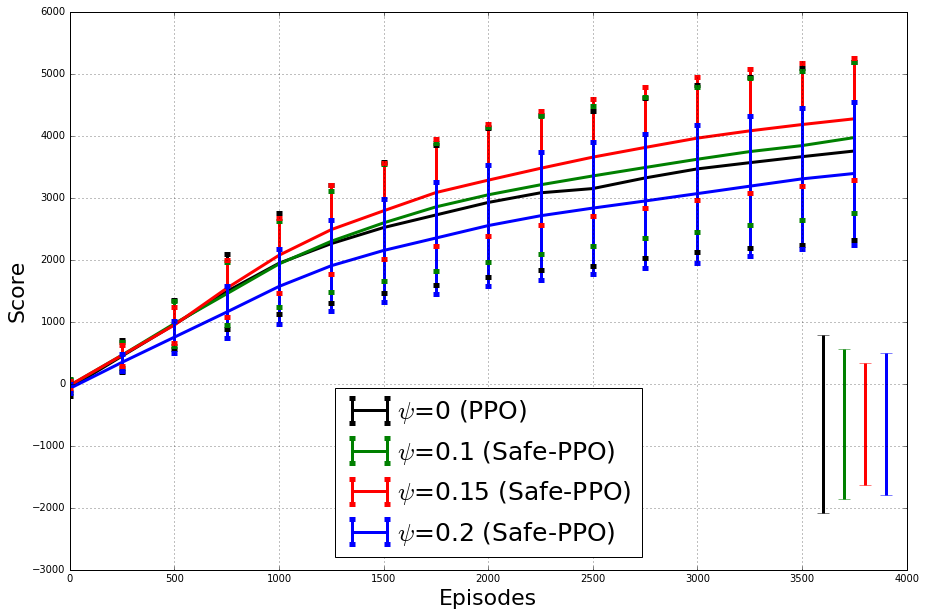

In [3]:
#intermediate plots
folder_name = "../src/log-files" # Add location from where to read data
save_folder_name = "../EpisodePlots" # Add location of where to save plots
env_names = ["HalfCheetah", "Hopper", "Walker", "Ant", "Humanoid"]
env_index = 0 # 0: Half Cheetah, 1: Hopper, 2: Walker, 3: Ant
max_episodes = 4000
gap_episode = 5 #gap for Halfcheetah = 5, # gap for Walker, Hopper and Ant = 20
ratios = float(max_episodes/gap_episode)
episodes = np.arange(1,int(ratios)+1)*gap_episode
psi_vals = ["0.0","0.1","0.15","0.2"]

psi_labels = ["0 (PPO)","0.1 (Safe-PPO)","0.15 (Safe-PPO)","0.2 (Safe-PPO)"]
colors_list = ["k","g","r","b","orange", "y"]
dir_names = listdir(folder_name)
psi_reward_dict = defaultdict(list)
min_size_reward = max_episodes
max_steps = int(max_episodes/gap_episode)
for c_psi in psi_vals:
    for d in dir_names:
        if os.path.isdir(os.path.join(folder_name,d)):
            if env_names[env_index] in d and (("_Psi"+ c_psi+"_") in d):
                dfs=[]
                run_files = listdir(os.path.join(folder_name,d))
                for run_ind in run_files:
                    if "Run" not in run_ind:
                        continue
                    if not os.path.isdir(os.path.join(folder_name,d,run_ind)):
                        continue
                    file_name = join(folder_name, d, run_ind,'log.csv')
                    dfs.append(pd.read_csv(file_name))
                rewards = []
                for df in dfs:
                    x = df.as_matrix(["_MeanReward"])
                    psi_reward_dict[c_psi].append(x[:int(ratios)].flatten())                    
psi_list =[]
reward_list= []
for psi_val in psi_reward_dict.keys():
    psi_list.append(psi_val)
    reward = np.asarray(psi_reward_dict[psi_val])
    reward_list.append(reward)

window = 50
print("reward list: ", len(reward_list))
length = int(reward_list[0].shape[1]/ window)
fig, ax = plt.subplots(figsize=(15, 10))
first_yaxis = 0. 

first_loc = []
for k in range(len(psi_list)):
    print("k is :", k)
    print("shape:",reward_list[k].shape)
    mean_reward = np.mean(reward_list[k], axis = 0).flatten()
    std_dev_reward = np.std(reward_list[k], axis = 0).flatten()
    new_reward = np.zeros(length+1)
    new_reward_std = np.zeros(length+1)
    x_axis = []
    
    for i in range(length+1):
        new_reward[i] = np.mean(mean_reward[i*window : i*window + window])
        new_reward_std[i] = np.mean(std_dev_reward[i*window : i*window + window])
        x_axis.append(i*gap_episode*window)
    
    mean_val_std_dev = std_dev_reward[-40:].mean() # Make it -40 if gap is 5, else 10 is gap is 20. We are evaluating performance at last 200 episodes
    mean_val_mean = mean_reward[-10:].mean()
    
    print("psi :",psi_list[k])
    std_plt = round(mean_val_std_dev,1)
    print("Std Dev: ", std_plt)
    print("mean: ",round (mean_val_mean,1))
    
    ax.errorbar(x_axis, new_reward, new_reward_std, label = "$\psi$="+psi_labels[k],
                 barsabove=True, linewidth = 3,capthick = 5, color = colors_list[k] )
    
    axis_coordinates_of_representative_error_bar = (0.90 + k*0.025,0.05)
    screen_coordinates_of_representative_error_bar = ax.transAxes.transform(axis_coordinates_of_representative_error_bar)
    screen_to_data_transform = ax.transData.inverted().transform
    data_coordinates_of_representative_error_bar = screen_to_data_transform(screen_coordinates_of_representative_error_bar)
    foo = data_coordinates_of_representative_error_bar
    if k == 0:
        first_yaxis = foo[1]
    else:
        foo[1] = first_yaxis
    ax.errorbar(foo[0], foo[1], yerr=std_plt, capsize=6,linewidth=3, color = colors_list[k],barsabove=True)
    if k==0:
        first_loc.append(foo[0])
        first_loc.append(foo[1])

plt.xlabel("Episodes",fontsize=22)
plt.ylabel("Score",fontsize=22)
plt.grid(b=True)
plt.legend(prop={'size': 25}, loc='best', handletextpad=0.1)
# plt.savefig(os.path.join(save_folder_name, env_names[env_index]+"_reward.png"), dpi=400, facecolor='w', edgecolor='w',
#            orientation='portrait', papertype=None, format=None,
#            transparent=True, bbox_inches='tight', pad_inches=0,
#            frameon=None)
plt.show()
plt.close()